# Chapter 16: Contextual Word Embeddings with Transformers

In [2]:
!pip install transformers evaluate portalocker sentence-transformers torchdata

In [ ]:
!wget https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/educational_transformer.py

In [3]:
from educational_transformer import PositionalEncoding, EncoderLayer, EncoderTransf

In [ ]:
# Required for PyTorch 2.3
import torch
torch.utils.data.datapipes.utils.common.DILL_AVAILABLE = torch.utils._import_utils.dill_available()

In [ ]:
import torchtext
torchtext.disable_torchtext_deprecation_warning()

## 16.3 Attention Is All You Need

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch14/translation_att.png)

## 16.4 Transformer

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch14/stacked_layers.png)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch14/full_transformer.png)

## 16.5 An Encoder-Based Model for Classification

### 16.5.1 AG News Dataset

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step1.png)

In [6]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step2.png)

In [7]:
import numpy as np

chr_codes = np.array([
     36,   151,    38,  8220,   147,   148,   146,   225,   133,    39,  8221,  8212,   232,   149,   145,   233,
  64257,  8217,   163,   160,    91,    93,  8211,  8482,   234,    37,  8364,   153,   195,   169
])
chr_subst = {f' #{c};':chr(c) for c in chr_codes}
chr_subst.update({' amp;': '&', ' quot;': "'", ' hellip;': '...', ' nbsp;': ' ', '&lt;': '', '&gt;': '',
                  '&lt;em&gt;': '', '&lt;/em&gt;': '', '&lt;strong&gt;': '', '&lt;/strong&gt;': ''})

In [8]:
def replace_chars(sent):
    to_replace = [c for c in list(chr_subst.keys()) if c in sent]
    for c in to_replace:
        sent = sent.replace(c, chr_subst[c])
    return sent

def preproc_description(desc):
    desc = desc.replace('\\', ' ').strip()
    return replace_chars(desc)

In [9]:
from torchdata.datapipes.iter import FileLister
from torch.utils.data import DataLoader

def create_raw_datapipe(fname):
    datapipe = FileLister(root='.')
    datapipe = datapipe.filter(filter_fn=lambda v: v.endswith(fname))
    datapipe = datapipe.open_files(mode='rt', encoding="utf-8")
    datapipe = datapipe.parse_csv(delimiter=",", skip_lines=0)
    datapipe = datapipe.map(lambda row: (int(row[0])-1, preproc_description(row[2])))
    return datapipe

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step4.png)

In [ ]:
datapipes = {}
datapipes['train'] = create_raw_datapipe('train.csv').shuffle(buffer_size=125000)
datapipes['test'] = create_raw_datapipe('test.csv')

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step5.png)

In [ ]:
dataloaders = {}
dataloaders['train'] = DataLoader(dataset=datapipes['train'], batch_size=32, shuffle=True)
dataloaders['test'] = DataLoader(dataset=datapipes['test'], batch_size=32)

### 16.5.2 Tokenizing and Padding

In [17]:
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
import os

new_locations = {key: os.path.join('https://huggingface.co/stanfordnlp/glove/resolve/main',
                                   os.path.split(GloVe.url[key])[-1]) for key in GloVe.url.keys()}
GloVe.url = new_locations

.vector_cache/glove.6B.zip: 862MB [00:08, 102MB/s]                           
100%|█████████▉| 400000/400001 [00:12<00:00, 31709.51it/s]


In [ ]:
tokenizer = get_tokenizer('basic_english')

vector = GloVe(name='6B', dim=50)
d_model = vector.dim

max_length = 100
n_outputs = 4

In [18]:
def fixed_length(tokens_batch, max_len=100, pad_token='<pad>'):
    truncated = [s[:max_len] for s in tokens_batch]
    current_max = max([len(s) for s in truncated])
    padded = [s + [pad_token]*(current_max-len(s)) for s in truncated]
    return padded

In [19]:
labels, sentences = next(iter(dataloaders['train']))

tokenized_X = [tokenizer(d) for d in sentences]
padded_X = fixed_length(tokenized_X, max_len=max_length-1) # subtracts one bc we're adding the CLS token
' '.join(padded_X[1])

'expos first baseman nick johnson was hit on the side of the head by a hard grounder in the third inning and was carried off the field on a stretcher . johnson immediately went down face first onto the infield . the expos said johnson never lost . . . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [20]:
import torch

# If a BoolTensor is provided, positions with True is not allowed to attend while False values will be unchanged.
# https://pytorch.org/tutorials/beginner/translation_transformer.html
# src_padding_mask = (src == PAD_IDX).transpose(0, 1)

pad_mask = torch.as_tensor([[w == '<pad>' for w in s] for s in padded_X])
pad_mask[1].shape, pad_mask[1]

(torch.Size([99]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True]))

### 16.5.3 Word Embeddings

In [21]:
src = torch.cat([vector.get_vecs_by_tokens(s).unsqueeze(0) for s in padded_X], dim=0)
src[1].shape, src[1]

(torch.Size([99, 50]),
 tensor([[-0.5284,  0.1121, -0.3542,  ...,  0.2603, -0.0482,  0.4774],
         [-0.1417,  0.4111, -0.3123,  ..., -0.2542,  0.0178, -0.1489],
         [-1.3734,  0.4023,  0.0225,  ..., -0.2093, -0.6685,  1.1150],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]))

### 16.5.4 Classifier Token

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [22]:
import torch.nn as nn

cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
# Special classifier token
# 1, 1, D -> N, 1, D
cls_tokens = cls_token.expand(len(padded_X), -1, -1)
cls_tokens.shape, cls_tokens

(torch.Size([32, 1, 50]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<ExpandBackward0>))

In [23]:
# Concatenates CLS tokens -> N, 1 + L, D
embeddings = torch.cat((cls_tokens, src), dim=1)
embeddings[1].shape, embeddings[1]

(torch.Size([100, 50]),
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.5284,  0.1121, -0.3542,  ...,  0.2603, -0.0482,  0.4774],
         [-0.1417,  0.4111, -0.3123,  ..., -0.2542,  0.0178, -0.1489],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
        grad_fn=<SelectBackward0>))

In [24]:
cls_mask = torch.zeros(len(padded_X), 1)
pad_mask = torch.cat((cls_mask, pad_mask), dim=1).bool()
pad_mask[1].shape, pad_mask[1]

(torch.Size([100]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True]))

### 16.5.5 Positioning

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [25]:
pe = PositionalEncoding(max_length, d_model)
pe.pe.shape

torch.Size([1, 100, 50])

In [26]:
embeddings = pe(embeddings)
embeddings[1].shape, embeddings[1]

(torch.Size([100, 50]),
 tensor([[ 0.0000,  1.0000,  0.0000,  ...,  1.0000,  0.0000,  1.0000],
         [-2.8950,  1.3327, -1.8667,  ...,  2.8408, -0.3408,  4.3757],
         [-0.0925,  2.4906, -1.2255,  ..., -0.7977,  0.1263, -0.0529],
         ...,
         [ 0.3796, -0.9251, -0.9062,  ...,  0.9998,  0.0140,  0.9999],
         [-0.5734, -0.8193, -0.9676,  ...,  0.9998,  0.0142,  0.9999],
         [-0.9992,  0.0398, -0.5841,  ...,  0.9998,  0.0143,  0.9999]],
        grad_fn=<SelectBackward0>))

### 16.5.6 Hidden States

In [27]:
layer = EncoderLayer(n_heads=2, d_model=d_model, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1, max_len=max_length)

In [28]:
hidden_states = encoder(embeddings, pad_mask)
hidden_states.shape

torch.Size([32, 100, 50])

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch14/cls_hidden_state.png)

### 16.5.7 Classifier "Head"

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [29]:
# Gets state from first token only: [CLS]
cls_state = hidden_states[:, 0, :]  # N, D
cls_state.shape

torch.Size([32, 50])

In [30]:
mlp = nn.Linear(d_model, n_outputs)

logits = mlp(cls_state) # N, outputs
logits.shape

torch.Size([32, 4])

In [31]:
class TransfClassifier(nn.Module):
    def __init__(self, tokenizer, vector, encoder, n_outputs):
        super().__init__()
        # Our "hybrid" transformer takes an instance of the
        # Vector class, such as GloVe to retrieve the word
        # embeddings
        self.vector = vector
        # The number of dimensions (D) of the model is the
        # same as the size of the embeddings
        self.d_model = vector.dim
        # The tokenizer that will be used - it needs to
        # produce tokens that are understood by the Vector
        # GloVe's vocabulary is made of full words (not subwords)
        # so the tokenizer must produce full words as well
        self.tokenizer = tokenizer
        # The number of outputs/classes the model should
        # produce logits for
        self.n_outputs = n_outputs
        
        # The underlying structure of the model is
        # made of a Transformer Encoder
        self.encoder = encoder
        # The MLP is the classifier "head" that maps
        # the hidden state produced by the classifier token
        # to the number of outputs (logits)
        self.mlp = nn.Linear(self.d_model, n_outputs)
        # These are the embeddings corresponding to the
        # special classifier token, which are going to
        # be learned during training - they are a parameter
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.d_model))
        
        # Positional encoding will add positional information
        # according to the maximum sequence length, and number
        # of dimenions of the embeddings
        self.pe = PositionalEncoding(self.encoder.pe.max_len, self.d_model)

    def preprocess(self, X):
        # in a mini-batch of N sequences
        # gets embeddings (size D) for each token
        # in the sequence (size L)
        # N, L -> N, L, D
        src = torch.cat([self.vector.get_vecs_by_tokens(s).unsqueeze(0) for s in X], dim=0)
        
        # creates a mini-batch (size N) of special classifier tokens
        # each token has same size as embeddings (D)
        # 1, 1, D -> N, 1, D
        # it's part of the model (created as nn.Parameter), so it is sent to the device
        # with the rest of the model
        cls_tokens = self.cls_token.expand(len(X), -1, -1)  
        
        # Concatenates CLS tokens to the source embeddings 
        # N, 1 + L, D
        src = torch.cat((cls_tokens, src.to(cls_tokens.device)), dim=1)
        return src

    def encode(self, source, source_mask=None):
        # Encoder generates "hidden states"
        # src to L, N, D and output states back to N, L, D
        states = self.encoder(source, source_mask)
        return states

    @staticmethod
    def source_mask(X):
        # If a BoolTensor is provided, positions with True is not allowed to attend
        # while False values will be unchanged.
        
        # Original code
        # https://pytorch.org/tutorials/beginner/translation_transformer.html
        # src_padding_mask = (src == PAD_IDX).transpose(0, 1)
        
        # the classifier token shouldn't be ignored, so its mask is zero/False
        cls_mask = torch.zeros(len(X), 1)
        # for every padding token, we set the mask to True
        pad_mask = torch.as_tensor([[w == '<pad>' for w in s] for s in X])
        # concatenates the mask for the classifier tokens to
        # the regular padding mask
        pad_mask = torch.cat((cls_mask, pad_mask), dim=1).bool()
        return pad_mask # N, D

    def forward(self, X):
        # tokenizes each sentence in the mini-batch
        tokenized_X = [self.tokenizer(d) for d in X]
        # pads all tokenized sequences to max length minus one
        # subtracts one bc we're adding the CLS token
        padded_X = fixed_length(tokenized_X, max_len=99)

        device = next(iter(self.parameters())).device

        # calls the preprocess method to get the embeddings
        # and the special token embedding prepended to it
        embeddings = self.preprocess(padded_X).to(device)
        # add positional information to the embeddings
        src = self.pe(embeddings)
        # generates the mask to identify the padding tokens
        mask = self.source_mask(padded_X).to(device)

        # Featurizer - uses a Transformer Encoder to 
        # produce hidden states (same size as embeddings)
        # which are going to used as features
        states = self.encode(src, mask)
        # Gets state from first token only: [CLS]
        cls_state = states[:, 0, :]  # N, 1, D
        # Uses the state produced by the classifier token
        # to feed the classifier "head" (MLP) that
        # produces logits
        out = self.mlp(cls_state) # N, 1, outputs

        # Gets the attention scores of the attention heads
        # in the last encoder layer to visualize them later
        alphas = self.encoder.layers[-1].self_attn_heads.alphas
        return {'hidden_states': states,
                'logits': out,
                'embeddings': embeddings,
                'alphas': alphas[:, :, 0, :].squeeze()}

In [32]:
tokenizer = get_tokenizer('basic_english')

vector = GloVe(name='6B', dim=50)
d_model = vector.dim

max_length = 100
n_outputs = 4

layer = EncoderLayer(n_heads=2, d_model=d_model, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1, max_len=max_length)
model = TransfClassifier(tokenizer, vector, encoder, n_outputs=4)

In [33]:
labels, sentences = next(iter(dataloaders['train']))

model.eval()
out = model(sentences)
out.keys()

dict_keys(['hidden_states', 'logits', 'embeddings', 'alphas'])

In [34]:
out['alphas'].shape, out['alphas']

(torch.Size([32, 2, 74]),
 tensor([[[0.0270, 0.0160, 0.0121,  ..., 0.0000, 0.0000, 0.0000],
          [0.0278, 0.0103, 0.0111,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0427, 0.0185, 0.0505,  ..., 0.0000, 0.0000, 0.0000],
          [0.0500, 0.0315, 0.0243,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0325, 0.0244, 0.0194,  ..., 0.0000, 0.0000, 0.0000],
          [0.0365, 0.0175, 0.0203,  ..., 0.0000, 0.0000, 0.0000]],
 
         ...,
 
         [[0.0544, 0.0293, 0.0314,  ..., 0.0000, 0.0000, 0.0000],
          [0.0633, 0.0291, 0.0291,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0616, 0.0256, 0.0306,  ..., 0.0000, 0.0000, 0.0000],
          [0.0542, 0.0457, 0.0624,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0519, 0.0242, 0.0328,  ..., 0.0000, 0.0000, 0.0000],
          [0.0666, 0.0295, 0.0308,  ..., 0.0000, 0.0000, 0.0000]]]))

### 16.5.8 Training

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step4.png)

In [37]:
datapipes = {}
datapipes['train'] = create_raw_datapipe('train.csv').shuffle(buffer_size=125000)
datapipes['test'] = create_raw_datapipe('test.csv')

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step5.png)

In [ ]:
dataloaders = {}
dataloaders['train'] = DataLoader(dataset=datapipes['train'], batch_size=32, shuffle=True)
dataloaders['test'] = DataLoader(dataset=datapipes['test'], batch_size=32)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [35]:
torch.manual_seed(11)

tokenizer = get_tokenizer('basic_english')

vector = GloVe(name='6B', dim=50)
d_model = vector.dim

max_length = 100
n_outputs = 4

layer = EncoderLayer(n_heads=2, d_model=d_model, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1, max_len=max_length)
model = TransfClassifier(tokenizer, vector, encoder, n_outputs=4)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step2.png)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step3.png)

In [36]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step4.png)

In [38]:
batch_losses = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

## Training
for i, batch in enumerate(dataloaders['train']):
    model.train()

    labels, sentences = batch
    labels = labels.to(device)

    # Step 1 - forward pass
    predictions = model(sentences)['logits']

    # Step 2 - computing the loss
    loss = loss_fn(predictions, labels)

    # Step 3 - computing the gradients
    loss.backward()
    batch_losses.append(loss.item())

    # Step 4 - updating parameters and zeroing gradients
    optimizer.step()
    optimizer.zero_grad()

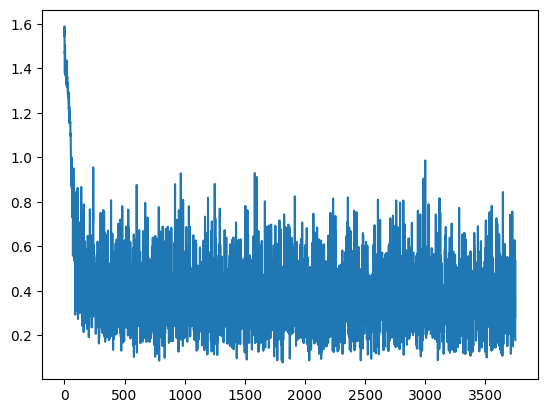

In [39]:
from matplotlib import pyplot as plt
plt.plot(batch_losses)

### 16.5.9 Evaluation

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step5.png)

In [40]:
import evaluate

metric1 = evaluate.load('precision', average=None)
metric2 = evaluate.load('recall', average=None)
metric3 = evaluate.load('accuracy')

In [41]:
model.eval()

for batch in dataloaders['test']:
    labels, sentences = batch
    labels = labels.to(device)

    # Step 1 - forward pass
    predictions = model(sentences)['logits']

    pred_class = predictions.argmax(dim=1).tolist()
    labels = labels.tolist()

    metric1.add_batch(references=labels, predictions=pred_class)
    metric2.add_batch(references=labels, predictions=pred_class)
    metric3.add_batch(references=labels, predictions=pred_class)

In [42]:
metric1.compute(average=None), metric2.compute(average=None), metric3.compute()

({'precision': array([0.93608124, 0.94579246, 0.87051207, 0.76113537])},
 {'recall': array([0.82473684, 0.96421053, 0.77842105, 0.91736842])},
 {'accuracy': 0.8711842105263158})

### 16.5.10 Visualizing Attention

In [43]:
labels, sentences = next(iter(dataloaders['train']))

model.eval()
out = model(sentences)
scores = out['alphas']
scores.shape

torch.Size([32, 2, 63])

In [44]:
top_idxs = scores[:, :, 1:].argmax(dim=2).tolist()
top_idxs[:3]

[[2, 13], [2, 5], [32, 0]]

In [46]:
import pandas as pd

class_labels = ['world', 'sports', 'business', 'sci/tech']

results = [(class_labels[label], class_labels[prediction], tokens[idxs[0]], tokens[idxs[1]], description)
 for tokens, idxs, label, prediction, description in
 zip([tokenizer(s) for s in sentences], top_idxs, labels.tolist(), out['logits'].argmax(dim=1).tolist(), sentences)]

pd.DataFrame(results, columns=['Label', 'Prediction', 'Head #1', 'Head #2', 'News'])

,Label,Prediction,Head #1,Head #2,News
0,world,world,president,head-to-head,AFP - President George W. Bush and Democratic ...
1,business,business,technology,suing,A Marlborough-based technology company is suin...
2,business,sci/tech,renewable,toronto,TORONTO (CP) - More towering wind turbines wil...
3,sports,sports,ensure,giants,Scottish giants Rangers bowed out of the UEFA ...
4,business,business,nigeria,com,"NEW YORK, November 12 (newratings.com) - Crude..."
5,sci/tech,sci/tech,technology,electronics,A new micro-generator developed at the Georgia...
6,sports,sports,keyarena,wnba,"A day later, Simone Edwards could not get over..."
7,business,business,reuters,smallest,Reuters - U.S. employment costs rose by slight...
8,sports,sports,rarified,cricket,JUSTIN Langer sniffed the rarified air of cric...
9,business,business,reuters,shares,PARIS (Reuters) - Euro Disney shares leapt on ...


## 16.6 Contextual Embeddings

In [47]:
sentences = ("The core of the planet is becoming unstable.",
             "The shift in the company's core business markets had impacted their quartely results.")

In [48]:
model.eval()
out = model(sentences)
out['logits'].argmax(dim=1).tolist()

[3, 2]

In [49]:
idx0 = tokenizer(sentences[0]).index('core') + 1  # because [CLS] is 0th index
idx1 = tokenizer(sentences[1]).index('core') + 1  # because [CLS] is 0th index
idx0, idx1

(2, 8)

In [50]:
(out['embeddings'][0][idx0] == out['embeddings'][1][idx1]).all()

tensor(True, device='cuda:0')

In [51]:
out['hidden_states'][0][idx0], out['hidden_states'][1][idx1]

(tensor([-0.4800, -0.2095,  1.3268,  0.0564,  1.6651,  0.4922,  0.4572, -1.9419,
         -0.2720,  0.5216,  0.7877, -0.8487, -0.6101,  0.5547, -1.4379,  0.8544,
          0.0330,  1.1315,  0.8597, -0.8195,  0.2245, -0.5256, -0.1670, -0.1030,
         -0.6864, -0.6838, -0.7107,  0.1160,  0.2288,  0.5223,  5.0292, -0.1434,
         -0.1265, -0.9635, -0.2364,  0.1066, -1.1363, -0.1622, -0.3544, -0.5475,
         -0.3097, -1.5920, -0.7958,  0.4493,  0.1269,  0.7292,  0.4355,  0.6510,
         -0.7403, -0.1589], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([-0.5404, -0.0697,  0.9760,  0.2633,  1.2838,  0.1626,  0.4119, -2.4007,
         -0.2140,  0.2779,  0.9887, -1.0020, -0.5095,  0.6046, -1.2375,  0.7846,
          0.0361,  1.1440,  0.8627, -0.8627,  0.3753, -0.4836, -0.1821,  0.0184,
         -0.5982, -0.7430, -0.6037,  0.0848,  0.2705,  0.6254,  5.0393, -0.1377,
         -0.0457, -0.8924, -0.2150,  0.0756, -1.0748, -0.1583, -0.3188, -0.6005,
         -0.2097, -1.6472, -0.8252, 

### 16.6.1 Sentence Embeddings

In [52]:
sentence_embeddings = out['hidden_states'][:, 0]
sentence_embeddings

tensor([[-0.2623, -0.3917, -1.3004,  0.8506, -0.4111, -0.9447, -0.1666,  0.1712,
          0.1929,  0.3416,  0.6254,  0.2255,  1.3198, -1.1652, -1.5061,  1.3255,
          0.7650, -1.2185,  0.6924, -0.2123, -1.2289,  0.9395, -0.4131, -0.6954,
         -0.2677,  2.5027, -1.4659, -0.1315, -1.6879, -0.5194,  0.9799,  1.3943,
          0.3624, -0.4270,  0.9723,  0.9110, -0.5196,  1.6910, -0.6767,  1.4577,
         -1.4912,  1.0425,  0.3184, -0.4279, -1.8246,  2.1614, -0.8162, -0.7830,
          0.9584, -0.4869],
        [-1.9966,  0.0614, -1.0541,  1.2015, -0.9124, -0.7634, -0.6722, -0.3881,
         -1.4024,  1.3906,  0.9317, -0.0755,  0.6108,  0.3469, -0.4553,  0.1634,
         -0.5886, -1.0406, -0.5684, -0.5755, -0.0550,  1.3103, -1.3453,  0.7730,
          0.9302,  1.6968, -0.2013, -0.9414, -1.5358,  0.8766, -0.1108,  1.4371,
          1.2279,  0.7346,  0.9313,  0.4679,  0.4084,  1.5377, -0.9382,  0.5372,
         -0.7199,  0.0647, -0.6894, -0.8269, -2.6205,  2.4495, -0.2196,  0.7346,


### 16.6.3 Zero-Shot Text Classification Revisited

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step5.png)

In [53]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

sentences = ['world', 'sports', 'business', 'science and technology']
labels_emb = model.encode(sentences, convert_to_tensor=True)
labels_emb.shape

torch.Size([4, 384])

In [54]:
import evaluate

metric1 = evaluate.load('precision', average=None)
metric2 = evaluate.load('recall', average=None)
metric3 = evaluate.load('accuracy')

In [55]:
cos = nn.CosineSimilarity(dim=-1)

for i, batch in enumerate(dataloaders['test']):
    labels, sentences = batch

    embeddings = model.encode(sentences, convert_to_tensor=True)

    distances = cos(embeddings.unsqueeze(1), labels_emb)

    pred_class = distances.argmax(dim=1)

    metric1.add_batch(references=labels, predictions=pred_class)
    metric2.add_batch(references=labels, predictions=pred_class)
    metric3.add_batch(references=labels, predictions=pred_class)

In [56]:
metric1.compute(average=None), metric2.compute(average=None), metric3.compute()

({'precision': array([0.6580743 , 0.75671982, 0.55060571, 0.57694826])},
 {'recall': array([0.45684211, 0.87421053, 0.74157895, 0.46368421])},
 {'accuracy': 0.6340789473684211})